# Hierarchical Refinement with OTT‑JAX: Scalable Optimal Transport

This tutorial provides a hands-on introduction to the **Hierarchical Refinement** (HiRef) algorithm using the `LRSinkhorn` low-rank solver from `OTT‑JAX`.
 
Originally proposed by Halmos et al. (2025) [paper](https://arxiv.org/pdf/2503.03025), HiRef is designed to scalably compute **bijective** optimal transport (OT) maps between two datasets of equal size. It overcomes memory bottlenecks associated with traditional OT solvers by leveraging a multiscale strategy built on low-rank optimal transport couplings.

## Introduction

### Background

Optimal transport aims to align two probability distributions with minimal cost. In the discrete setting, when both distributions are uniform and supported on $n$ points, the OT problem reduces to the **Monge assignment problem**:

$$
\min_{T: \{1, \dots, n\} \to \{1, \dots, n\} \text{ bijective}} \sum_{i=1}^{n} c(x_i, y_{T(i)}),
$$

where $X = \{x_i\}_{i=1}^n$ and $Y = \{y_j\}_{j=1}^n$ are two sets of points in $\mathbb{R}^d$, and $c(x, y)$ is a cost function (typically squared Euclidean distance). Solving this exactly requires cubic time using algorithms like the Hungarian method or Network Simplex, which becomes intractable for large $n$.

### The HiRef Idea

HiRef sidesteps this cubic cost by computing **a hierarchy of low-rank OT subproblem**



### Tutorial outline

1. Installation & Setup
2. Step by step explanation of the algorithm
3. Implementation of HiRef Algorithm
4. Visualizing results
5. About computational time
6. Improvements

## 1. Installation & Setup

* Installing ```OTT‑JAX``` and other basic libraries
 
* We strongly recommend to use the **```0.5.0``` version** which is the latest stable version of ```OTT-JAX```

In [16]:
# Requirements:
"""
%pip install --upgrade pip
%pip install jax==0.6.0 jaxlib==0.6.0 ott-jax==0.5.0
%pip install ipykernel
%pip install matplotlib
%pip intall numpy
"""

'\n%pip install --upgrade pip\n%pip install jax==0.6.0 jaxlib==0.6.0 ott-jax==0.5.0\n%pip install ipykernel\n%pip install matplotlib\n%pip intall numpy\n'

In [17]:
from functools import lru_cache 
from typing import Callable

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.initializers.linear.initializers_lr import Rank2Initializer
from ott.solvers.linear.sinkhorn_lr import LRSinkhorn

In [18]:
print("OTT_JAX version:", ott.__version__)

OTT_JAX version: 0.5.0


## 2. Step by step explanation of HiRef Algorithm

In this paragraphe we will explain step by step how HiRef Algorithm works, the implementation of the algorithm is available in 3.

### 2.1 Generating data examples
The `HiRef` algorithm computes a full-rank alignment between two equally sized input datasets $X$ and $Y$. Therefore, the point clouds must be the same size and have uniform mass. For best results—and to align naturally with HiRef’s binary partitioning—choose $n$ to be a power of 2 (typically 128 points).
 
For convenience we will work on vectors of size 2, in order to be able to plot them in 2D. HiRef Algorithm however is not restricted in dimensions (except for computational reasons).
 
In our exemple our source is the concatenation of two normal distributions in 2D one shifted from the other, and with the same number of points. Our target is the concatenation of two uniform distribution in 2D one shifted from the other, but in one hub we have 2/3 of our target points and in the other hub the last 1/3.
 
We will use a small number of points (n=32) just for better visualisation, you can increase this number to better see the distributions.

In [19]:
def create_points(rng, n, d, distribution="shifted"):
    """
    Generate two toy point clouds of equal size and dimension.

    Parameters
    ----------
    rng : jax.random.PRNGKey
        A JAX random number generator key.
    n : int
        The number of points in each point cloud.
    d : int
        The dimensionality of each point.

    Returns
    -------
    x : jnp.ndarray of shape (n, d)
        Point cloud drawn from a standard normal distribution.
    y : jnp.ndarray of shape (n, d)
        Point cloud drawn from a uniform distribution on [4, 8).
    """
    # split key
    key_x, key_y = jax.random.split(rng)

    if distribution == "normal":
        x = jax.random.normal(key_x, (n, d))
        y = jax.random.normal(key_y, (n, d))*20 + 20
    
    elif distribution=="shifted":
        
        # Construction of source dataset X
        half = n // 2
        x1 = jax.random.normal(key_x, (half, d))
        x2 = jax.random.normal(key_x, (n - half, d)) + 20.0
        x = jnp.concatenate([x1, x2], axis=0)

        # Construction of target dataset Y
        third = n//3
        y1 = jax.random.uniform(key_y, (third, d), minval=20.0, maxval=30.0)
        y2 = jax.random.uniform(key_y, (n - third, d), minval=3.0, maxval=8.0)
        y = jnp.concatenate([y1, y2], axis=0)

    else :
        print("Le paramètre version doit être égal à 'normal' ou 'shifted'")

    return x, y

In [20]:
rng = jax.random.key(4)
n, d =  32, 2
x, y = create_points(rng, n=n, d=d)

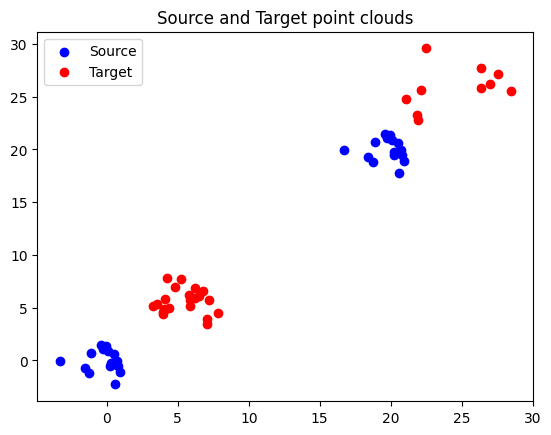

In [21]:
plt.scatter(x[:, 0], x[:, 1], label="Source", color="blue", alpha=1)
plt.scatter(y[:, 0], y[:, 1], label="Target", color="red", alpha=1)
plt.legend()
plt.title("Source and Target point clouds")
plt.show()

### 2.2 Low rank partition with ott-jax LRSinkhorn

#### 2.2.1 Basics behing Hi Ref Algorithm

##### Why a low-rank OT solver?

`LRSinkhorn` implements the low-rank optimal transport (OT) formulation introduced by Scetbon *et al.* (2021). Instead of searching over all admissible $n\times m$ transport matrices, we restrict attention to matrices that factorize as

$$
P_r \;=\; Q\,\mathrm{diag}\bigl(1/g\bigr)\,R^\top,
$$

where:

- **$r$** is the **rank of the approximation**, i.e., the number of intermediate clusters used to represent the transport plan.  
  It controls the trade-off between **accuracy and efficiency**. This rank defines the number of columns in $Q$ and $R$, and the dimension of the vector $g$.

- $Q \in \mathbb{R}^{n \times r}$ is the **soft-cluster assignment matrix of source points**.  
  It assigns each **source point** (each row) to a mixture over $r$ intermediate clusters and determines how much of the source point’s mass is routed through each of the intermediate clusters. So, $Q_{i,z}$ represents **the proportion of mass from source point $i$** that is assigned to cluster $z$.

- Similarly, the matrix $R \in \mathbb{R}^{m \times r}$ is the **soft-cluster assignment of target points**. It assigns each **target point** to a mixture over the same $r$ clusters and determines how much of the incoming mass to target point $j$ comes from cluster $z$. This allows the source and target distributions to be connected via shared intermediate hubs.

- The vector $g \in \Delta^r$ is a probability distribution over the $r$ clusters.  
It controls **how much total mass** flows through each cluster and determines the relative importance of each cluster in the overall transport. In many implementations, such as `HiRef`, $g$ is fixed to be uniform (i.e., $g_z = 1/r$).

For small rank $r$, this reduces memory complexity to $\mathcal{O}\bigl((n + m)\,r\bigr)$ and enables log-linear runtimes.

##### Uniform $g$ and rank $=2$ in `HiRef`

`HiRef` builds on that idea: if $g$ can be kept uniform, every column of $Q$ perfectly "co-clusters" a set of source points with the corresponding column of $R$ on the target side; recursing on each block yields a bijective Monge map in $O(n\log n)$ time.

Especially, **Proposition 3.1** of Halmos *et al.* proves that if $ g = \left(\frac{1}{2}, \frac{1}{2}\right) $ and $ r = 2 $,  thus the maximisers of $Q$ and $R$ partition $X$ and $Y$ into two subsets that are perfectly matched by the Monge map $T^*(x)$.

The original paper enforces uniformity of the vector $g$ by letting a KL-penalty $\tau \to \infty$.
 
However `OTT-JAX 0.5.0` does not expose $\tau$, but we can mimic the same constraint with:

- A large $\gamma$ – this shrinks the mirror-descent step on $g$, so it moves very slowly away from its initial uniform value [Optimal Transport Tools].
- A floor $\text{min\_value} \approx \frac{1}{r}$ inserted through `kwargs_dys`, which Dykstra applies after every update, preventing any $g_k$ from dropping below the uniform target.

##### Configuring LRSinkhorn for HiRef

- `rank=2` – enforces two sub-blocks per level.

- `gamma=1e5` – drives $g$ towards $(\tfrac{1}{2}, \tfrac{1}{2})$ without numerical blow-ups

- `gamma_rescale=True` – rescales $\gamma$ internally each iteration, improving gradient conditioning on difficult costs 

- `kwargs_dys={'min_entry_value': 0.49}` – places a floor slightly below $1/r$ to stop any row of $Q$ or $R$ collapsing, which would violate the HiRef invariant.

- `lse_mode=True` – performs updates in log-space, preventing overflow when $\gamma$ is huge

- `jax.jit` – compiles the solver once; subsequent calls run at native XLA speed, amortizing cost across HiRef’s many recursive partitions.

- `Rank2Initializer` - best suited to low rank problem, but more costly than Gaussian Initializer

#### 2.2.2 First example on rank = 2

##### Implementation of LRSinkhorn and resolving problem of rank = 2

In [22]:
# We will create our optimal transport problem between the two point clouds

# Create the geometry
geom    = pointcloud.PointCloud(x, y)

# Initialize the problem
ot_prob = linear_problem.LinearProblem(geom)

# Initialize the initializer used for the solver
initializer = Rank2Initializer(rank=2)

# Initialize the solver
solver = jax.jit(LRSinkhorn(
    rank=2,
    initializer=initializer,
    gamma=1e4,
    gamma_rescale=True,
    kwargs_dys = {'min_entry_value' : 1/2 * (1- 1e-2)},
    lse_mode=True,
))

In [23]:
# We solve the problem thanks to our solver defined above
out = solver(ot_prob)

# We can now visualize the results
Q, R, g = out.q, out.r, out.g

##### Point assignment to a specific partition using `LRSinkhorn` output

The **`LRSinkhorn` algorithm** outputs two low-rank matrices $Q$ and $R$ that approximate the optimal transport plan between a source block $X$ and a target block $Y$.

- Each row of $Q \in \mathbb{R}^{n \times r}$ corresponds to a source point $x_i \in X$.
- Each row of $R \in \mathbb{R}^{m \times r}$ corresponds to a target point $y_j \in Y$.
- The entries in each row of $Q$ and $R$ represent **soft assignments** to $r$ intermediate clusters.

To assign each point to a specific partition (i.e., a hard clustering):

- For each source point $x_i$, we assign it to the cluster index with the highest weight:

  $$
  \ell_X(i) = \arg\max_{z \in \{1, \dots, r\}} Q_{iz}
  $$

- For each target point $y_j$, we similarly assign:

  $$
  \ell_Y(j) = \arg\max_{z \in \{1, \dots, r\}} R_{jz}
  $$

This procedure yields **co-clusterings** of the source and target datasets.  

In particular, when $r = 2$, this defines two matched partitions $x_1$ and $x_2$ of $X$ and similarly $y_1$ and $y_2$ for $Y$ that can be refined recursively in hierarchical OT algorithms like `HiRef`.

##### Partition thanks to LRSinkhorn of rank = 2

In [24]:
# We get the best clustering of the source and target point clouds
# by looking at the maximum values of the transport plan Q and R
# for each point in the source and target point clouds respectively

q_labels = jnp.argmax(Q, axis=1)
r_labels = jnp.argmax(R, axis=1)

# We will now create the clusters
clusters = []

# For every indice of clusters we should expect (2 in rank 2 problem)
for idx_cluster in range(2):
    idx_x = jnp.where(q_labels == idx_cluster)[0]
    idx_y = jnp.where(r_labels == idx_cluster)[0]

    if len(idx_x) == 0 or len(idx_y) == 0:
        continue  # Ignore clusters vides

    # Get the points in the source and target point clouds that belong to this cluster
    x_subblock = x[idx_x]
    y_subblock = y[idx_y]
    clusters.append((x_subblock, y_subblock))



Cluster 1 : 16 points in source, 16 points in target
Cluster 2 : 16 points in source, 16 points in target


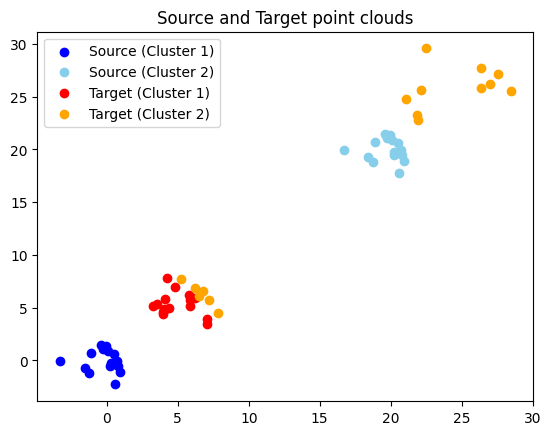

In [25]:
cluster_1 = clusters[0]
cluster_2 = clusters[1]

print(f"Cluster 1 : {cluster_1[0].shape[0]} points in source, {cluster_1[1].shape[0]} points in target")
print(f"Cluster 2 : {cluster_2[0].shape[0]} points in source, {cluster_2[1].shape[0]} points in target")

# We can now visualize the clusters : source points
plt.scatter(cluster_1[0][:, 0], cluster_1[0][:, 1], label="Source (Cluster 1)", color="blue", alpha=1)
plt.scatter(cluster_2[0][:, 0], cluster_2[0][:, 1], label="Source (Cluster 2)", color="skyblue", alpha=1)

# We can now visualize the clusters : target points
plt.scatter(cluster_1[1][:, 0], cluster_1[1][:, 1], label="Target (Cluster 1)", color="red", alpha=1)
plt.scatter(cluster_2[1][:, 0], cluster_2[1][:, 1], label="Target (Cluster 2)", color="orange", alpha=1)

plt.legend()
plt.title("Source and Target point clouds")
plt.show()

Here we observe that our two cluster have been equally separated. Morever the result of the partition looks realistic, when we see wich source cluster goes to which target cluster. In our case the partition worked well but this result is not always that ways...

#### 2.2.3 Coutering approximation made by LRSinkhorn

##### Why Some Partitions Can Be Unbalanced?

In theory, when using `LRSinkhorn` with $r = 2$ and enforcing a **uniform constraint** on $g = (1/2, 1/2)$, the resulting partitions of $X$ and $Y$ — obtained by applying $\arg\max$ to the rows of $Q$ and $R$ — should divide each dataset into two **perfectly balanced** blocks of equal size.

In our `HiRef` implementation, however, we do **not explicitly fix** $g$. Instead, we use a large penalty parameter $\gamma = 10^5$ and apply a **lower bound** on the entries of $g$ by setting `kwargs_dys["min_entry_value"] ≈ 1/r`. This simple trick is usually sufficient to keep the Kullback–Leibler divergence between $g$ and the uniform vector below $10^{-3}$. This low Kullback–Leibler divergence indicates that $g$ stays very close to the uniform distribution $\bigl(\tfrac12,\tfrac12\bigr)$.
 
Even though $g$ stays close to uniform, the $\arg\max$ hard assignment of points to clusters can still lead to slightly **unbalanced partitions**, especially if some rows of $Q$ or $R$ are close to uniform (i.e., ties or near-ties between clusters):

In [26]:
rng = jax.random.key(4)
n, d =  2050, 2
x_, y_ = create_points(rng, n=n, d=d)

In [27]:
# Create the geometry
geom_ = pointcloud.PointCloud(x_, y_)
# Initialize the problem
ot_prob_ = linear_problem.LinearProblem(geom_)

out_ = solver(ot_prob_)

Q_, R_, g_ = out_.q, out_.r, out_.g

# We get the best clustering of the source and target point clouds
q_labels = jnp.argmax(Q_, axis=1)
r_labels = jnp.argmax(R_, axis=1)

# We will now create the clusters
clusters = []

# For every indice of clusters we should expect (2 in rank 2 problem)
for idx_cluster in range(2):
    idx_x = jnp.where(q_labels == idx_cluster)[0]
    idx_y = jnp.where(r_labels == idx_cluster)[0]

    if len(idx_x) == 0 or len(idx_y) == 0:
        continue  # Ignore clusters vides

    # Get the points in the source and target point clouds that belong to this cluster
    x_subblock = x_[idx_x]
    y_subblock = y_[idx_y]
    clusters.append((x_subblock, y_subblock))

cluster_1 = clusters[0]
cluster_2 = clusters[1]

print(f"Cluster 1 : {cluster_1[0].shape[0]} points in source, {cluster_1[1].shape[0]} points in target")
print(f"Cluster 2 : {cluster_2[0].shape[0]} points in source, {cluster_2[1].shape[0]} points in target")

Cluster 1 : 1028 points in source, 1040 points in target
Cluster 2 : 1022 points in source, 1010 points in target


We see that our partition is not well balanced in terms of source and target data. 
 
But the real problem is that for our different clusters, the number of source points and target points may be different. This will prevent us from being able to find a bijection between source and target. In fact, different source points maybe transported to the same target, and so the opposite.
  
To prevent this phenomen from happening we will implement an hard clustering method.

##### Dealing with umbalanced partition

**Slightly unbalanced partitions** are harmless in practice, and the recursive nature of HiRef continues to produce bijective alignments at the finest scale.


However, if you want to ensure that each partition contains **exactly** $\text{round}(g_k \cdot n)$ points, we provide an alternative hard assignment function: `simple_balanced_partition`.

This method:
- Respects the target cluster proportions encoded in $g$,
- Assigns each point to its most likely cluster (based on $Q$),
- Enforces **exact cluster sizes** by construction,
- Is useful when you need a **strict bijective alignment** in downstream applications (e.g., deterministic block pairing in `HiRef`).

Using this function instead of $\arg\max$, gives you **full control** over the size of each partition and can avoid accidental size mismatches during recursive refinement steps.

In [28]:
def simple_balanced_partition(Q: jnp.ndarray, g: jnp.ndarray):
    """
    Q: matrice (n, k) de scores pour chaque point i et cluster k
    g: vecteur (k,) de poids relatifs pour chaque cluster
    Retourne labels: (n,) avec exactement sum(labels==k) = round(g[k]*n)
    """
    n, k = Q.shape

    # 1) Capacités idéales
    caps = jnp.round(g * n).astype(int)
    # Ajuste pour que caps.sum()==n si petits décalages d'arrondi
    diff = n - caps.sum()
    if diff != 0:
        # on ajoute +1 au cluster(s) de plus grand g jusqu'à combler diff
        order = jnp.argsort(-g)
        for idx in order[:abs(diff)]:
            caps = caps.at[idx].add(jnp.sign(diff))

    # 2) Assignation simple, cluster par cluster
    labels = -jnp.ones(n, dtype=int)
    assigned = jnp.zeros(n, dtype=bool)
    # On parcourt les clusters dans l’ordre décroissant de g (pour donner priorité aux grands clusters)
    for cluster in jnp.argsort(-g):
        # indices des points non encore assignés
        rem = jnp.where(~assigned)[0]
        # on trie ces points par score Q[:,cluster] décroissant
        scores_rem = Q[rem, cluster]
        order_rem = rem[jnp.argsort(-scores_rem)]
        # on prend les premiers caps[cluster] parmi eux
        chosen = order_rem[: caps[cluster]]
        labels = labels.at[chosen].set(cluster)
        assigned = assigned.at[chosen].set(True)

    return labels

In [29]:
q_labels = simple_balanced_partition(Q_, g_)
r_labels = simple_balanced_partition(R_, g_)

In [30]:
clusters = []

# For every indice of clusters we should expect (2 in rank 2 problem)
for idx_cluster in range(2):
    idx_x = jnp.where(q_labels == idx_cluster)[0]
    idx_y = jnp.where(r_labels == idx_cluster)[0]

    if len(idx_x) == 0 or len(idx_y) == 0:
        continue  # Ignore clusters vides

    # Get the points in the source and target point clouds that belong to this cluster
    x_subblock = x_[idx_x]
    y_subblock = y_[idx_y]
    clusters.append((x_subblock, y_subblock))

cluster_1 = clusters[0]
cluster_2 = clusters[1]

print(f"Cluster 1 : {cluster_1[0].shape[0]} points in source, {cluster_1[1].shape[0]} points in target")
print(f"Cluster 2 : {cluster_2[0].shape[0]} points in source, {cluster_2[1].shape[0]} points in target")

Cluster 1 : 1029 points in source, 1029 points in target
Cluster 2 : 1021 points in source, 1021 points in target


Now we ensure to have as many source points as target points in our different clusters.

## 3. Implementation of Hierachical Refinement Algorithm and Rank Schedule

The `HiRef` function implements the core loop of the **HiRef algorithm**, progressively refining the matching between two datasets `x` and `y` by solving low-rank optimal transport problems at multiple scales. It returns a list of matched index pairs `(i, j)`. These pairs represent a **final bijective alignment** between the datasets, built through iterative co-clustering and refinement.

Our HiRef algorithm uses a **while loop** to progressively refine the matching (a recursive loop is also possible as in the article). The clusters are stored and processed until they reduce to size 1, at which point the matching is complete. This iterative approach avoids recursion by maintaining an explicit queue of clusters to process.

The input blocks are split into `rank` co-clusters. Depending on the value of the `balanced_partition` flag:

- If `True`, the split is performed using `simple_balanced_partition`, ensuring that each sub-block contains exactly the expected number of points.  
  *Note: this option is **computationally more expensive**, as it requires explicit selection logic rather than simple thresholding.*

- If `False`, a standard $\arg\max$ assignment is used to assign each point to its most likely cluster.

If either `x` or `y` is of size 1, the loop terminates.  
When `balanced_partition=True`, the two blocks are always of equal size, so the base case will yield one-to-one assignments between equally sized sub-blocks.

For each cluster $z \in \{0, \dots, r-1\}$, if the corresponding sub-block in `x` or `y` is empty, it is skipped. Otherwise, the function processes the sub-blocks `x_z` and `y_z`, propagating their corresponding indices. The matched pairs returned from all steps are aggregated into a growing list.

### Key Parameters

- The `rank schedul` parameter controls how many sub-blocks each dataset is split into at every step. For example, `rank=2` (as used in the original HiRef paper) creates a binary tree of iterative refinements.

- If `balanced_partition=True`, the source and target blocks are always split into sub-groups of exactly the same size. This is important when you want to maintain a **bijective mapping** between the datasets throughout the hierarchy.


### Requirements

In [31]:
from functools import lru_cache 
from typing import Callable
import time
import functools


import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.initializers.linear.initializers_lr import Rank2Initializer
from ott.solvers.linear.sinkhorn_lr import LRSinkhorn

### 3.1 Rank Schedule

Before implementing the HiRef algorithm, we should consider the following problem:

We use `LRSinkhorn` with `rank = 2` to split our partition into two parts. For instance, if we consider a dataset of \( 2^n \) points, we recursively split the dataset into two clusters, then each of those into two, and so on. This results in solving approximately:

$$
iterations = 2 + 2 \cdot 2 + 2^3 + \dots + 2^n
$$

transport problems, which may become computationally expensive.

To optimize the computational time of the algorithm, the authors propose the following strategy: instead of always using a rank-2 solver, we can try using other small ranks in order to minimize the total number of iterations required.

The next function implements this idea — it's a simplified but functional version of the original rank-annealing algorithm proposed by the authors.


In [32]:
def factor_decompositions(n, q):
    """Retourne toutes les décompositions possibles de n en facteurs ≤ q."""
    stack = [(n, 2, [])]  # (reste à factoriser, facteur_minimal, décomposition en cours)
    results = []

    while stack:
        current_n, start_factor, current_decomp = stack.pop()

        if current_n == 1:
            results.append(current_decomp)
            continue

        for f in range(start_factor, min(q, current_n) + 1):
            if current_n % f == 0:
                new_n = current_n // f
                stack.append((new_n, f, current_decomp + [f]))

    return results


def decomposition_cost(factors):
    """Coût d'une décomposition : somme des produits partiels."""
    cost = 0
    product = 1
    for f in factors:
        product *= f
        cost += product
    return cost

def rank_decomposition(n, q):
    """Retourne la meilleure décomposition de n en facteurs ≤ q selon le coût."""
    all_decomps = factor_decompositions(n, q)
    if not all_decomps:
        return None  # Pas de décomposition possible
    best = min(all_decomps, key=decomposition_cost)

    print(f'Optimized rank schedule: {best}')
    
    return best


### 3.2 Compilation of our solvers

**Caching Solvers and Initializers for Efficiency**

Since we will use different solvers to resolve Low Rank Optimal Transport (LROT) problems with various ranks, it is crucial to cache the results of the `jax.jit` method. This caching strategy allows us to initialize each solver only once, which significantly reduces computation time as the dataset size increases.

Additionally, we apply the same caching strategy to our initializers to optimize the performance further.

**Note**: The `maxsize` parameter can be adjusted based on your specific needs.


In [33]:
@functools.lru_cache(maxsize=10)
def get_initializer(rank):
    """
    This function is used to keep in cache the initializer initialized with the rank.
    """
    return Rank2Initializer(rank=rank)


@functools.lru_cache(maxsize=10)
def get_solver(rank):
    """
    This function is used to keep in cache the solver initialized with the rank.
    Thanks to jax.jit we can compile the function once and use it multiple times.
    """
    initializer = get_initializer(rank)
    
    solver = jax.jit(LRSinkhorn(
        rank=rank,
        initializer=initializer,
        gamma=1e4,
        gamma_rescale=True,
        kwargs_dys = {'min_entry_value' : 1/rank * (1- 1e-3)},
        lse_mode=True,
        ))
    
    return jax.jit(solver)

### 3.3 Well-balancing our clusters

**Hard Clustering Method**

As discussed earlier, we used a basic method for hard clustering the clusters obtained with LRSinkhorn. However, the authors employed more sophisticated methods for hard clustering. Our approach is a proposed solution that requires further refinement and improvement.


In [34]:
def simple_balanced_partition(Q: jnp.ndarray, g: jnp.ndarray) -> jnp.ndarray:
    """
    Assigns each point to a cluster such that the final partition is balanced
    according to the target proportions given by g.

    Args:
        Q: Array of shape (n, k) containing assignment scores for each point i and cluster k.
        g: Array of shape (k,) representing the relative weight (target proportion) for each cluster.

    Returns:
        labels: Array of shape (n,) where each entry is an integer in {0, ..., k-1},
                and exactly round(g[k] * n) points are assigned to each cluster k.
    """
    # number of data points, number of clusters
    n, k = Q.shape

    # compute target number of points per cluster (rounded to integers)
    caps = jnp.round(g * n).astype(int)

    # correct for rounding errors to ensure total adds up to n
    diff = n - caps.sum()
    if diff != 0:
        # sort clusters by descending target proportion
        order = jnp.argsort(-g)
        # Add or subtract 1 from top |diff| entries in g
        for idx in order[:abs(diff)]:
            caps = caps.at[idx].add(jnp.sign(diff))

    # prepare output: -1 means “unassigned” initially
    labels = -jnp.ones(n, dtype=int)
    # track which points have been assigned
    assigned = jnp.zeros(n, dtype=bool)

    # assign clusters in order of descending target weight
    for cluster in jnp.argsort(-g):
        # consider only points not yet assigned
        rem = jnp.where(~assigned)[0]
        # get their scores for this cluster
        scores_rem = Q[rem, cluster]
        # sort remaining points by descending score
        order_rem = rem[jnp.argsort(-scores_rem)]
        # pick top cap[cluster] points for this cluster
        chosen = order_rem[: caps[cluster]]
        # record their cluster labels
        labels = labels.at[chosen].set(cluster)
        # mark them as assigned
        assigned = assigned.at[chosen].set(True)

    return labels

### 3.4 HiRef Algorithm

In [35]:
def hiref_solver(
        X,              # jax array: Source points (n, d)
        Y,              # jax array: Target points (n, d)
        rank_schedule: list = None,  # if None, we will use the optimal rank schedule
        balanced_part: bool = True, # if True, we will use the balanced partition
        stock_block: bool = False, # if True, we stock the subblocks and stats
        stock_stats: bool = False, # if True, we stock the stats
        verbose: bool = False, # if True, print some stat during running
        ):
    """
    HiRef - version itérative utilisant ott-jax et low-rank Sinkhorn.
    
    Args:
        X (jax array): Points source (n, d).
        Y (jax array): Points cible (n, d).
        rank_schedule (list of int): Liste des rangs à utiliser à chaque profondeur.
        balanced_part (bool): Si True, on utilise la partition équilibrée.
        stocking (bool): Si True, on stocke les sous-blocs et les stats.
        verbose (bool): Si True, on affiche des stats pendant l'exécution.

    Returns:
        list of tuples (xi, yj): Les correspondances finales.
        list of tuples (t, n_s, n_c, depth): Les stats de chaque itération.
        list of tuples (t, x_block, y_block, x_subblock, y_subblock, depth): Les blocs traités.
    """

    n = X.shape[0]
    assert X.shape[0] == Y.shape[0], "X et Y doivent avoir la même taille."

    if rank_schedule is None:
        rank_schedule = rank_decomposition(n=n, q=5)
    print(f"Optimized rank-annealing schedule: {rank_schedule}")

    if stock_block:
        print("Stocking of subblocksn is activated.")

    if stock_stats:
        print("Stocking of stats is activated.")

    # Variables for storing stats and sub results
    stats = []  # (t, n_s, n_c, depth)
    blocks = []  # Liste pour stocker les blocs traités

    # List for bijective correspondences
    correspondances = []

    # Initialize time and iteration
    start = time.time()
    it = 0

    # Initialize the stack with the initial block
    stack = [(X, Y, 0)]

    while stack:
        # Our strategy is to unpack the stack (with pop method)
        # Our condition of exit is when the stack is empty 
        # This will happen when all points are matched
        x_block, y_block, depth = stack.pop()

        tempo = time.time() - start
        it += 1
        nb = len(x_block)
        ns = len(stack)
        nc = len(correspondances)

        if verbose:
            print(f"{it} : {depth} : [Correspondences size: {nc}]", end="\r")

        ### ------- EXIT CONDITION ------- ###
        ### Exit condition for our while loop. We want all elements to end at this step.

        # We put here a or condition. This or condition is needed when hard clustering is not activated.
        # When hard clustering is activated, this or condition is equivalent to an and condition.
        # Becaause we ensure that in a cluster that the number of source points and the number of target points are equal.
        
        if x_block.shape[0] == 1 or y_block.shape[0] == 1:
            correspondances.append((x_block[0], y_block[0]))
            if stock_stats:
                stats.append((it, tempo, ns, nc, (nb, x_block, y_block, rank), depth))
            if stock_block:
                blocks.append((it, x_block, x_block, y_block, y_block, depth + 1))
            continue

        ### ------- SPLITTING BLOCKS ------- ###
        # Define the rank to use; if the depth exceeds the length of the list, use a rank of 2
        rank = rank_schedule[depth] if depth < len(rank_schedule) else 2

        # Géométrie
        geom = pointcloud.PointCloud(x_block, y_block)

        # Problème de transport
        ot_prob = linear_problem.LinearProblem(geom)  
  
        # Initialiseur + solveur Low-Rank Sinkhorn
        solver = get_solver(rank)
        
        # Résoudre le problème de transport
        out = solver(ot_prob)

        # Récupérer Q et R
        Q = out.q
        R = out.r
        g = out.g

        # If we want to use the balanced partition, we will use the function simple_balanced_partition
        if balanced_part:
            q_labels = simple_balanced_partition(Q, g)
            r_labels = simple_balanced_partition(R, g)
        
        else:
            # Retrieve cluster labels
            q_labels = jnp.argmax(Q, axis=1)
            r_labels = jnp.argmax(R, axis=1)

        # For every cluster
        for idx_cluster in range(rank):
            idx_x = jnp.where(q_labels == idx_cluster)[0]
            idx_y = jnp.where(r_labels == idx_cluster)[0]

            if len(idx_x) == 0 or len(idx_y) == 0:
                continue  # Ignore clusters vides

            x_subblock = x_block[idx_x]
            y_subblock = y_block[idx_y]

            # Ajouter le sous-bloc à la pile
            stack.append((x_subblock, y_subblock, depth + 1))

        if stock_stats:
            stats.append((it, tempo, ns, nc, (nb, idx_x, idx_y, rank), depth))

        if stock_block:
            blocks.append((it, x_block, x_subblock, y_block, y_subblock, depth + 1))

    if verbose:
        print(f"total iterations : {it} - pairs : {len(correspondances)} - time : {tempo:.2f}s")

    return correspondances, stats, blocks

### 3.5 Bijective Transport Matrix and Transport Cost

Once the list of matched index pairs `(i, j)` has been computed by `HiRef`, we can build the corresponding **binary transport matrix** $P \in \{0, 1\}^{N \times N}$, where $P_{ij} = 1$ indicates that point $x_i$ is matched to $y_j$.

The matrix is initialized with zeros and updated entry by entry using the matched pairs. When `balanced_partition=False` (the default), the partitions may be slightly unbalanced, and some points may remain unmatched — resulting in rows or columns of $P$ that contain only zeros.

To assess the coverage of the matching, we can compute the percentage of points that were actually transported.

In [55]:
def bij_mat(x, y, pairs):
    """
    Create the bijective matrix of our solution
    """
    indice_x = {}
    indice_y = {}

    for i, x in enumerate(x):
        indice_x[tuple(x.tolist())] = i
    for i, y in enumerate(y):
        indice_y[tuple(y.tolist())] = i


    n = len(pairs)
    P = jnp.zeros((n, n), dtype=jnp.int32)
    for x, y in pairs:
        i = indice_x[tuple(x.tolist())]
        j = indice_y[tuple(y.tolist())]
        P = P.at[i, j].set(1)

    return P


def cost(x, y, P):
    """
    Compute the cost of the correspondences.
    
    Args:
        corresp: list of tuples (xi, yj) with xi and yj are the points in the source and target point clouds.
    
    Returns:
        cost: float, the cost of the correspondences.
    """
    C = jnp.sum((x[:, None, :] - y[None, :, :]) ** 2, axis=-1)

    transport_cost = jnp.sum(P * C)

    return transport_cost


def simple_cost(corresp):

    """
    Compute the cost of the correspondences.
    
    Args:
        corresp: list of tuples (xi, yj) with xi and yj are the points in the source and target point clouds.
    
    Returns:
        cost: float, the cost of the correspondences.
    """
    cost = 0
    for xi, yj in corresp:
        cost += jnp.linalg.norm(xi - yj)
    return cost

## 4. Visualisation HiRef Algorithm

### Creating small data of 32 points

In [37]:
rng = jax.random.key(4)
n, d = 32, 2
x, y = create_points(rng, n=n, d=d)

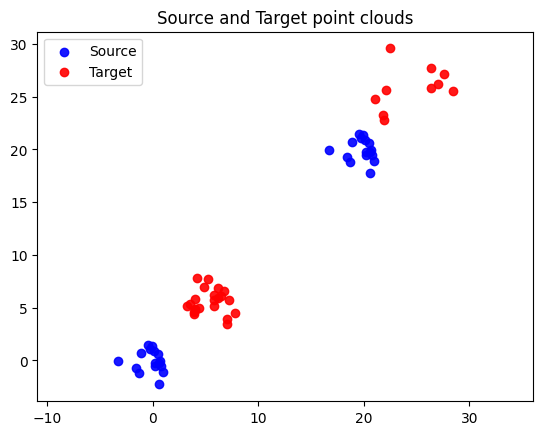

In [38]:
plt.scatter(x[:, 0], x[:, 1], label="Source", color="blue", alpha=0.9)   # bleu opaque
plt.scatter(y[:, 0], y[:, 1], label="Target", color="red", alpha=0.9)   # orange transparent
plt.legend()
plt.title("Source and Target point clouds")
plt.axis("equal")
plt.show()

### Rank Schedul and HiRef Solvers

In this part we will use two differents rank schedules resulting in two different hiref solver. The purpose of those two example is to see the impact of rank scheduling.

In [39]:
rs1 = rank_decomposition(n=n, q=6)
rs2 = rank_decomposition(n=n, q=2)

Optimized rank schedule: [2, 4, 4]
Optimized rank schedule: [2, 2, 2, 2, 2]


In [40]:
corresp1, stats1, blocks1 = hiref_solver(x, y, rank_schedule=rs1, verbose=True, stock_stats=True, stock_block=True, balanced_part=True)
corresp2, stats2, blocks2 = hiref_solver(x, y, rank_schedule=rs2, verbose=True, stock_stats=True, stock_block=True, balanced_part=True)

Optimized rank-annealing schedule: [2, 4, 4]
Stocking of subblocksn is activated.
Stocking of stats is activated.
total iterations : 43 - pairs : 32 - time : 3.96s
Optimized rank-annealing schedule: [2, 2, 2, 2, 2]
Stocking of subblocksn is activated.
Stocking of stats is activated.
total iterations : 63 - pairs : 32 - time : 2.71s


**Analysis of the Hiref Algorithms**

We can see that both of our Hiref algorithms transported every point, which means we ended up with a bijection. We can also observe that the number of iterations differs between the two Hiref methods.

- As expected, the number of iterations for Hiref 1 should be equal to:  
  $$ it = 1 + 2 + 2 \times 4 + 2 \times 4 \times 4 = 43 $$

- As expected, the number of iterations for Hiref 2 should be equal to:  
  $$ it = 1 + 2 + 2 \times 2 + 2 \times 2 \times 2 + 2 \times 2 \times 2 \times 2 + 2 \times 2 \times 2 \times 2 \times 2 = 63 $$

We should expect a difference in total cost.


### Correspondances and differences in transport

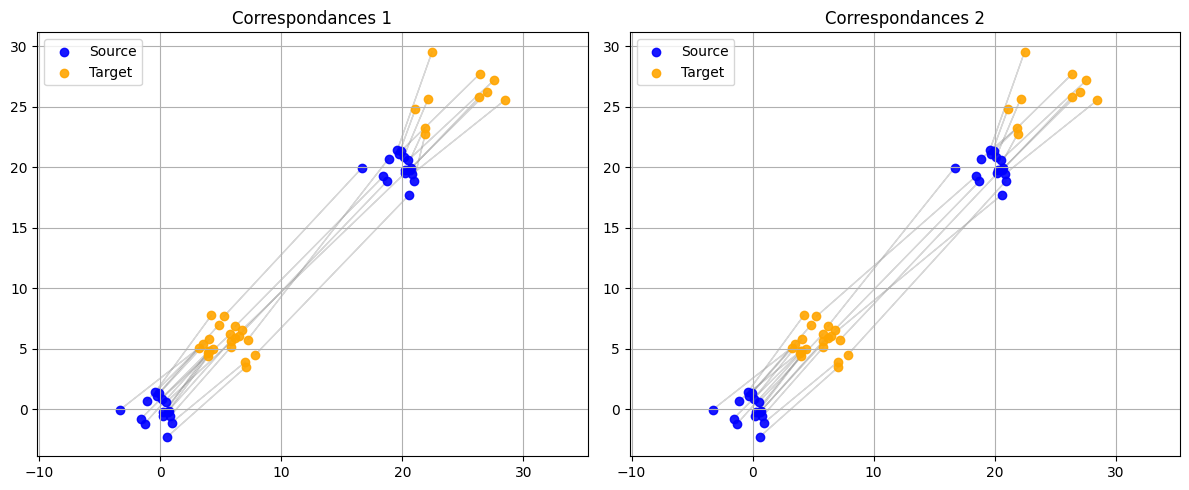

In [41]:
%matplotlib inline
plt.figure(figsize=(12, 5))  # Largeur étendue pour les deux subplots côte à côte

# Premier subplot (à gauche)
plt.subplot(1, 2, 1)
for xi, yj in corresp1:
    plt.arrow(xi[0], xi[1],
              yj[0] - xi[0],
              yj[1] - xi[1],
              head_width=0.0, alpha=0.3, length_includes_head=False, color="gray")
plt.scatter([xi[0] for xi, _ in corresp1], [xi[1] for xi, _ in corresp1],
            color='blue', alpha=0.9, label='Source')
plt.scatter([yj[0] for _, yj in corresp1], [yj[1] for _, yj in corresp1],
            color='orange', alpha=0.9, label='Target')
plt.title("Correspondances 1")
plt.axis("equal")
plt.grid(True)
plt.legend()

# Deuxième subplot (à droite)
plt.subplot(1, 2, 2)
for xi, yj in corresp2:
    plt.arrow(xi[0], xi[1],
              yj[0] - xi[0],
              yj[1] - xi[1],
              head_width=0.0, alpha=0.3, length_includes_head=False, color="gray")
plt.scatter([xi[0] for xi, _ in corresp2], [xi[1] for xi, _ in corresp2],
            color='blue', alpha=0.9, label='Source')
plt.scatter([yj[0] for _, yj in corresp2], [yj[1] for _, yj in corresp2],
            color='orange', alpha=0.9, label='Target')
plt.title("Correspondances 2")
plt.axis("equal")
plt.grid(True)
plt.legend()

plt.tight_layout()  # Pour éviter les chevauchements
plt.show()

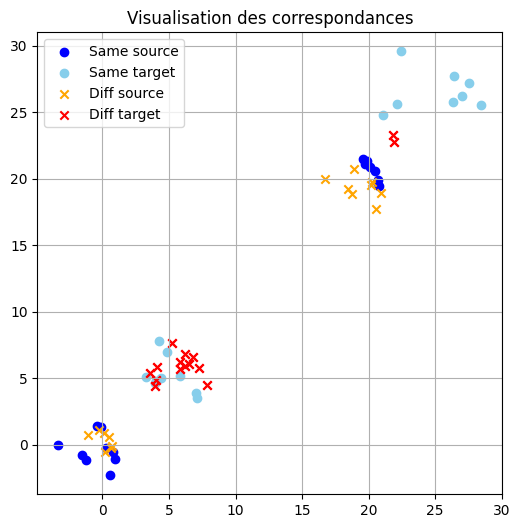

In [42]:
same_x = []
diff_x = []
same_y = []
diff_y = []

for (xi, yi) in corresp1:
    for (xj, yj) in corresp2:
        if jnp.allclose(xi, xj) and jnp.allclose(yi, yj):
            same_x.append(xi)
            same_y.append(yi)
        elif jnp.allclose(xi, xj):
            diff_x.append(xi)
            diff_y.append(yi)
            diff_y.append(yj)

same_x = np.array(same_x)
same_y = np.array(same_y)
diff_x = np.array(diff_x)
diff_y = np.array(diff_y)

%matplotlib inline
plt.figure(figsize=(6, 6))

# Points same (mêmes correspondances dans les deux)
if len(same_x) > 0:
    plt.scatter(same_x[:, 0], same_x[:, 1], color='blue', label='Same source', marker='o')
    plt.scatter(same_y[:, 0], same_y[:, 1], color='skyblue', label='Same target', marker='o')

# Points diff (même source mais cibles différentes)
if len(diff_x) > 0:
    plt.scatter(diff_x[:, 0], diff_x[:, 1], color='orange', label='Diff source', marker='x')
    plt.scatter(diff_y[:, 0], diff_y[:, 1], color='red', label='Diff target', marker='x')

plt.legend()
plt.title("Visualisation des correspondances")
plt.axis("equal")
plt.grid(True)
plt.show()


In [43]:
c1 = cost(corresp1)
c2 = cost(corresp2)
print(f"Cost of correspondences 1: {c1:.2f}")
print(f"Cost of correspondences 2: {c2:.2f}")

TypeError: cost() missing 2 required positional arguments: 'y' and 'P'

### Size of blocks being clustered

In [ ]:
t_1, t_2 = [], []
tempo_1, tempo_2 = [], []
ns_1, ns_2 = [], []
nc_1, nc_2 = [], []
nb_1, nb_2 = [], []
idx_x_1, idx_x_2 = [], []
idx_y_1, idx_y_2 = [], []
rank_1, rank_2 = [], []
depth_1, depth_2 = [], []

for t, tempo, ns, nc, (nb, idx_x, idx_y, rank), depth in stats1:
    t_1.append(t)
    tempo_1.append(tempo)
    ns_1.append(ns)
    nc_1.append(nc)
    nb_1.append(nb)
    idx_x_1.append(idx_x)
    idx_y_1.append(idx_y)
    rank_1.append(rank)
    depth_1.append(depth)

for t, tempo, ns, nc, (nb, idx_x, idx_y, rank), depth in stats2:
    t_2.append(t)
    tempo_2.append(tempo)
    ns_2.append(ns)
    nc_2.append(nc)
    nb_2.append(nb)
    idx_x_2.append(idx_x)
    idx_y_2.append(idx_y)
    rank_2.append(rank)
    depth_2.append(depth)

**Cluster Size and Iterations**

In the following figures, we can observe the size of the clusters based on the number of iterations. It's important to notice the impact of the rank schedule on these graphs. By analyzing the behavior of our while loop in the algorithm, we can better understand how it works.

For instance, for **HiRef1**:

- We start with the full cluster, which contains **32 points** \(2^5\).
- We then split it into **2 clusters** because our rank schedule is \([2, 4, 4]\), resulting in new clusters of size \(2^4\).
- These new clusters are added to the stack with a depth of 2, according to the rank schedule.
- Next, we work on one of the new clusters of size \(2^4\) (16 points).
- We split this cluster into **4 clusters** because the depth of this cluster is 2, and our rank schedule is \([2, 4, 4]\). The new cluster size becomes \(2^4 / 2^2 = 2^2\).
- This process continues, splitting clusters further


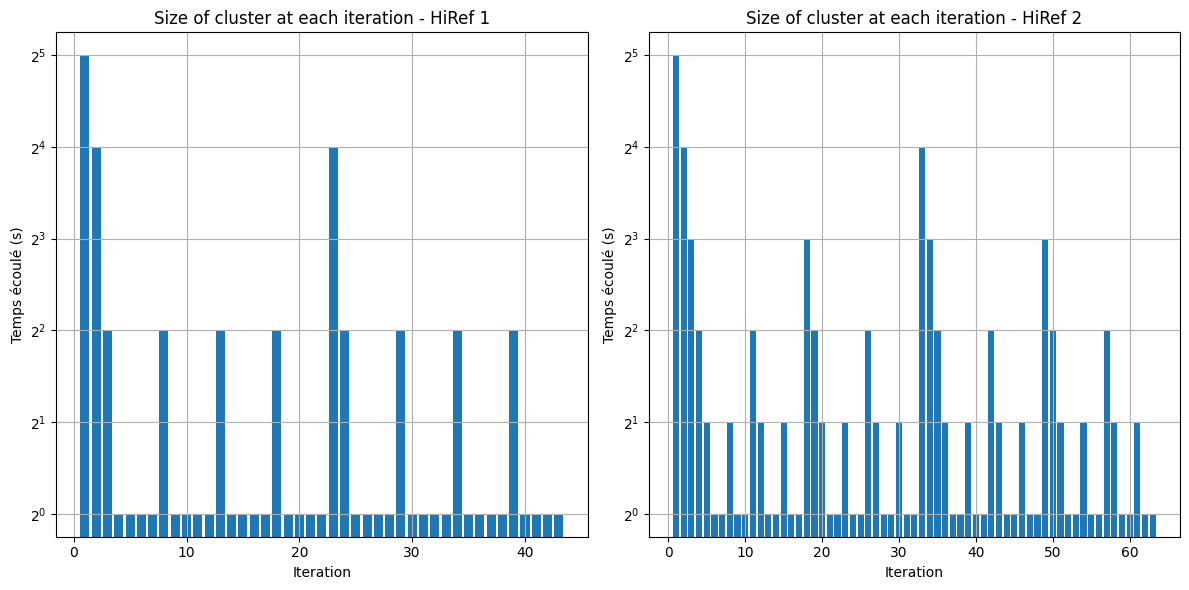

In [ ]:
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(t_1, nb_1)
plt.yscale('log', base=2)
plt.xlabel("Iteration")
plt.ylabel("Temps écoulé (s)")
plt.grid(True)
plt.title("Size of cluster at each iteration - HiRef 1")
plt.subplot(1, 2, 2)
plt.bar(t_2, nb_2)
plt.yscale('log', base=2)
plt.xlabel("Iteration")
plt.ylabel("Temps écoulé (s)")
plt.grid(True)
plt.title("Size of cluster at each iteration - HiRef 2")
plt.tight_layout()
plt.show()

### Tracking the indices

#### For HiRef 1 (rank_schedule = [2, 4, 4])

We are here following at each iteraation which point (represented by the index here) we are working on (blue squares), and whiwh points are being clustered together (orange circle). Here again we see the impact of rank schedule on the clusterization of our initial dataset.
 
Thus, it is quite nice to notice that, since our X dataset is very easy ti split in to 2 parts because it is the concatenation of two distribution, this can been seen in the index of our points.
The same exercice could be done with target points.

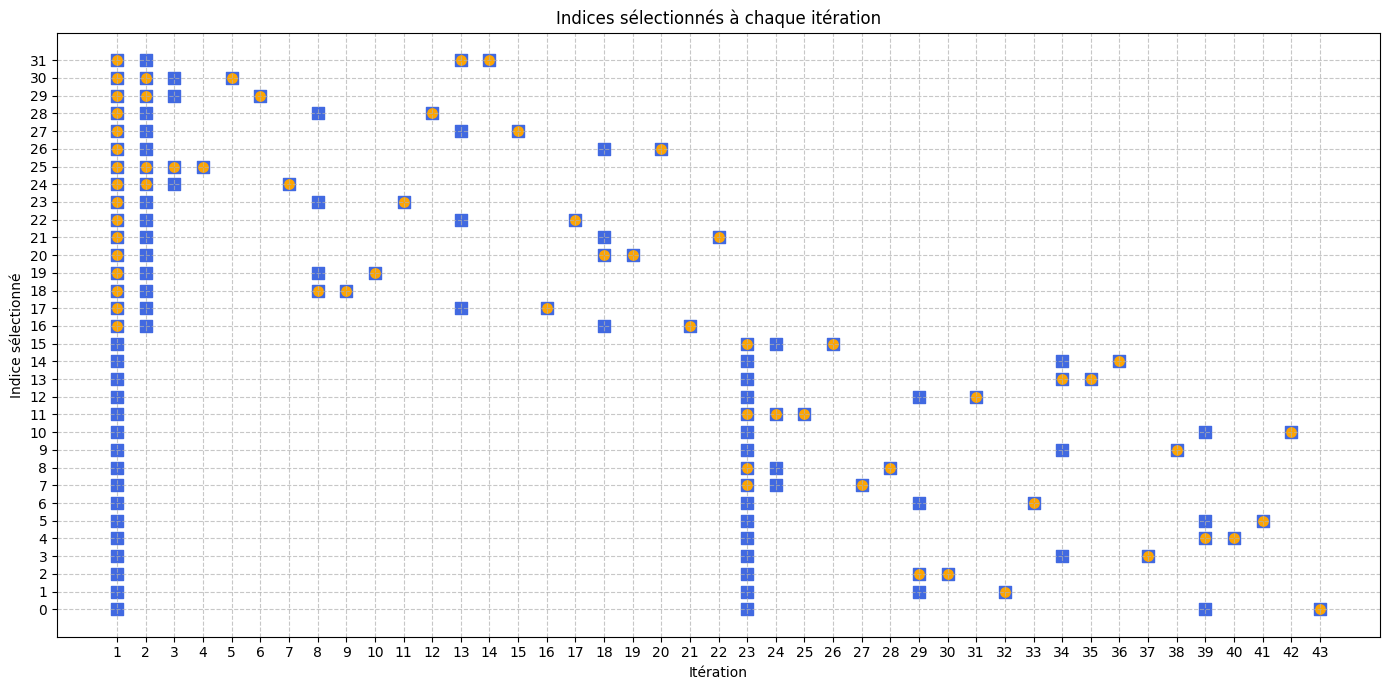

In [ ]:
x_coords = []
y_coords = []
xsub_coords = []
ysub_coords = []
indices = {}

for i, (tup) in enumerate(x):
    indices[tuple(tup.tolist())] = i

for t, xb, xsub, yb, ysub, depth in (blocks1):
    # On prend les indices de la matrice de transport
    for tup in xb:
        y_coords.append(indices[tuple(tup.tolist())])
        x_coords.append(t)
    for tup in xsub:
        ysub_coords.append(indices[tuple(tup.tolist())])
        xsub_coords.append(t)

      
"""
for i, indices in enumerate(idx_x_):
    x_coords.extend([i] * len(indices))  # Même x pour tous les y d'une itération
    y_coords.extend(indices.tolist())
"""
plt.figure(figsize=(14, 7))
plt.scatter(x_coords, y_coords, s=80, marker='s', color='royalblue')
plt.scatter(xsub_coords, ysub_coords, s=45, marker='o', color='orange')
plt.xlabel("Itération")
plt.ylabel("Indice sélectionné")
plt.title("Indices sélectionnés à chaque itération")

plt.xticks(np.arange(1,len(t_1)+1))
plt.yticks(np.arange(0, len(x)))
plt.grid(True, linestyle='--', alpha=0.7, which='major')
plt.tight_layout()
plt.show()


#### For HiRef 2 (rank_schedule = [2, 2, 2, 2])

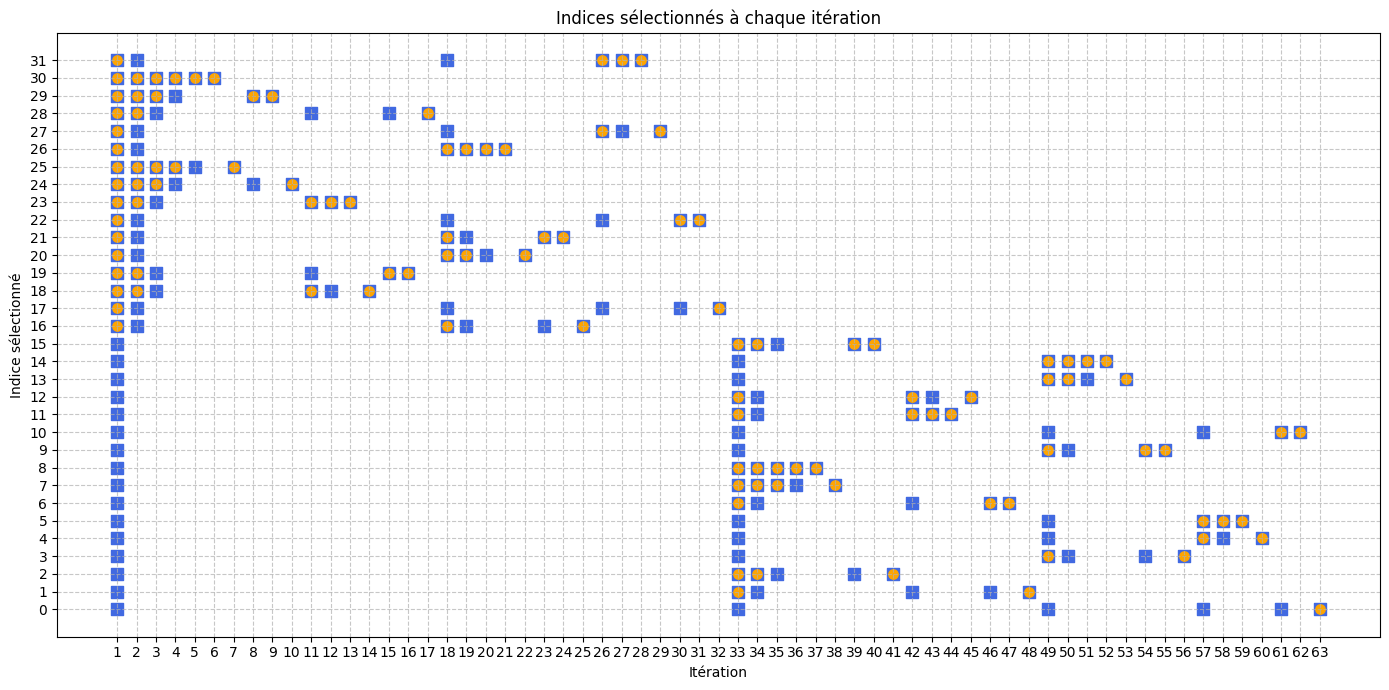

In [ ]:
x_coords = []
y_coords = []
xsub_coords = []
ysub_coords = []
indices = {}

for i, (tup) in enumerate(x):
    indices[tuple(tup.tolist())] = i

for t, xb, xsub, yb, ysub, depth in (blocks2):
    # On prend les indices de la matrice de transport
    for tup in xb:
        y_coords.append(indices[tuple(tup.tolist())])
        x_coords.append(t)
    for tup in xsub:
        ysub_coords.append(indices[tuple(tup.tolist())])
        xsub_coords.append(t)

      
"""
for i, indices in enumerate(idx_x_):
    x_coords.extend([i] * len(indices))  # Même x pour tous les y d'une itération
    y_coords.extend(indices.tolist())
"""
plt.figure(figsize=(14, 7))
plt.scatter(x_coords, y_coords, s=80, marker='s', color='royalblue')
plt.scatter(xsub_coords, ysub_coords, s=45, marker='o', color='orange')
plt.xlabel("Itération")
plt.ylabel("Indice sélectionné")
plt.title("Indices sélectionnés à chaque itération")

plt.xticks(np.arange(1,len(t_2)+1))
plt.yticks(np.arange(0, len(x)))
plt.grid(True, linestyle='--', alpha=0.7, which='major')
plt.tight_layout()
plt.show()

### Hiref iteration by iteration

#### For HiRef 1 (rank_schedule = [2, 4, 4])

This algorithm visualizes the progressive construction of hierarchical clusters during a multi-scale optimal transport procedure. At each depth of the hierarchy, the dataset is partitioned into finer clusters, and transport plans are computed between corresponding subsets. The animation shows how clusters at different levels (from coarse to fine) are matched between the source and target distributions. Each frame represents a particular clustering step, displaying the transport coupling at a specific depth.
 
Here again, the rank schedule has a key impact on the refinement.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.animation import FuncAnimation
import jax.numpy as jnp  # Si tu utilises jax
from IPython.display import HTML

_t = []
_xb = []
_xsub = []
_yb = []
_ysub = []
_depth = []
list_d = []

for t, xb, xsub, yb, ysub, depth in (blocks1):
    _t.append(t)
    _xb.append(xb)
    _xsub.append(xsub)
    _yb.append(yb)
    _ysub.append(ysub)
    _depth.append(depth)

_scat = []
for d in range(max(_depth) + 1):
    for i in range(len(_t)):
        if _depth[i] == d:
            _scat.append((_xb[i], _yb[i]))
            list_d.append(d)



# Créer la figure et l'axe
fig, ax = plt.subplots()
scat2 = ax.scatter([], [], c='skyblue', alpha=0.5)
scat = ax.scatter([], [], c='blue')

scat3 = ax.scatter([], [], c='orange', alpha=0.5)
scat4 = ax.scatter([], [], c='red', alpha=1.0)
ax.set_xlim(-4, 34)
ax.set_ylim(-4, 34)
title = ax.set_title("Animation de nuages de points")


# Fonction d'update
def update(frame):
    points = x  
    scat2.set_offsets(points)
    points = _scat[frame][0]
    scat.set_offsets(points)
    points = _scat[frame][1]
    scat4.set_offsets(points)
    points = y
    scat3.set_offsets(points)

    title.set_text(f"Animation de nuages de points – depth: {list_d[frame]}")
    return scat, scat2, scat3, scat4, title

# Créer l'animation
ani = FuncAnimation(fig, update, frames=len(_scat), interval=700, blit=True)

HTML(ani.to_jshtml())


<IPython.core.display.Javascript object>

#### For HiRef 2 (rank_schedule = [2, 2, 2, 2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.animation import FuncAnimation
import jax.numpy as jnp  # Si tu utilises jax
from IPython.display import HTML

_t = []
_xb = []
_xsub = []
_yb = []
_ysub = []
_depth = []
list_d = []

for t, xb, xsub, yb, ysub, depth in (blocks2):
    _t.append(t)
    _xb.append(xb)
    _xsub.append(xsub)
    _yb.append(yb)
    _ysub.append(ysub)
    _depth.append(depth)

_scat = []
for d in range(max(_depth) + 1):
    for i in range(len(_t)):
        if _depth[i] == d:
            _scat.append((_xb[i], _yb[i]))
            list_d.append(d)



# Créer la figure et l'axe
fig, ax = plt.subplots()
scat2 = ax.scatter([], [], c='skyblue', alpha=0.5)
scat = ax.scatter([], [], c='blue')

scat3 = ax.scatter([], [], c='orange', alpha=0.5)
scat4 = ax.scatter([], [], c='red', alpha=1.0)
ax.set_xlim(-4, 34)
ax.set_ylim(-4, 34)
title = ax.set_title("Animation de nuages de points")


# Fonction d'update
def update(frame):
    points = x  
    scat2.set_offsets(points)
    points = _scat[frame][0]
    scat.set_offsets(points)
    points = _scat[frame][1]
    scat4.set_offsets(points)
    points = y
    scat3.set_offsets(points)

    title.set_text(f"Animation de nuages de points – depth: {list_d[frame]}")
    return scat, scat2, scat3, scat4, title

# Créer l'animation
ani = FuncAnimation(fig, update, frames=len(_scat), interval=700, blit=True)

HTML(ani.to_jshtml())


<IPython.core.display.Javascript object>

## Computational Speed -- Let's race

The aim of this paragraph is to increase the number of points, and test different rank schedules to see the performance. It will be interesting also to test with or without our hard clustering method and finaly to test against classic Sinkhorn. Let us define our model :
* hiref_1 : renk scheduled relaxed with high value
* hiref_2 : renk scheduled relaxed with moderate
* hiref_3 : rank schedule with only 2s and 3s

### Our data

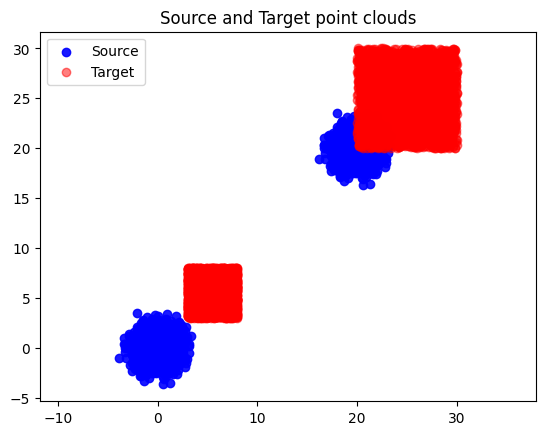

In [44]:
rng = jax.random.key(4)
n, d = 7776, 2
x, y = create_points(rng, n=n, d=d)

%matplotlib inline
plt.scatter(x[:, 0], x[:, 1], label="Source", color="blue", alpha=0.9)   
plt.scatter(y[:, 0], y[:, 1], label="Target", color="red", alpha=0.5) 
plt.legend()
plt.title("Source and Target point clouds")
plt.axis("equal")
plt.show()

### Running algorithms

In [45]:
rs1 = rank_decomposition(n=n, q=128)
rs2 = rank_decomposition(n=n, q=8)
rs3 = rank_decomposition(n=n, q=3)

Optimized rank schedule: [72, 108]
Optimized rank schedule: [3, 3, 3, 6, 6, 8]
Optimized rank schedule: [2, 2, 2, 2, 2, 3, 3, 3, 3, 3]


For a faire race, we clear the cache beafore every run.

In [46]:
get_initializer.cache_clear()
get_solver.cache_clear()
corresp1, stats1, blocks1 = hiref_solver(x, y, rank_schedule=rs1, verbose=True, stock_stats=True, stock_block=False, balanced_part=True)

Optimized rank-annealing schedule: [72, 108]
Stocking of stats is activated.
total iterations : 7859 - pairs : 7776 - time : 177.61s


In [47]:
get_initializer.cache_clear()
get_solver.cache_clear()
corresp2, stats2, blocks2 = hiref_solver(x, y, rank_schedule=rs2, verbose=True, stock_stats=True, stock_block=False, balanced_part=True)

Optimized rank-annealing schedule: [3, 3, 3, 6, 6, 8]
Stocking of stats is activated.
total iterations : 8958 - pairs : 7776 - time : 72.44s


In [48]:
get_initializer.cache_clear()
get_solver.cache_clear()
corresp3, stats3, blocks3 = hiref_solver(x, y, rank_schedule=rs3, verbose=True, stock_stats=True, stock_block=False, balanced_part=True)

Optimized rank-annealing schedule: [2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
Stocking of stats is activated.
total iterations : 11691 - pairs : 7776 - time : 99.14s


In [56]:

cost_1 = simple_cost(corresp1)
cost_2 = simple_cost(corresp2)
cost_3 = simple_cost(corresp3)


print(f"Cost of correspondences 1: {cost_1:.2f}")
print(f"Cost of correspondences 2: {cost_2:.2f}")
print(f"Cost of correspondences 3: {cost_3:.2f}")

Cost of correspondences 1: 68644.70
Cost of correspondences 2: 68322.88
Cost of correspondences 3: 68323.91


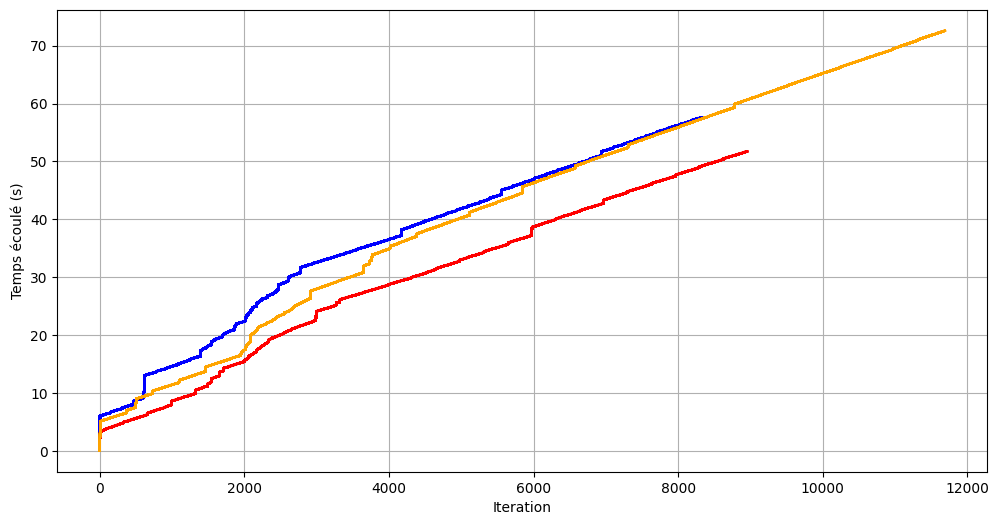

In [91]:
%matplotlib inline
plt.figure(figsize=(12, 6))
t_ = []
tempo_ = []
for t, tempo, ns, nc, (nb, idx_x, idx_y, rank), depth in stats1:
    t_.append(t)
    tempo_.append(tempo)
    plt.plot(t_, tempo_, label="Hiref 1", color="blue", alpha=0.9) 


t_.clear()
tempo_.clear()
for t, tempo, ns, nc, (nb, idx_x, idx_y, rank), depth in stats2:
    t_.append(t)
    tempo_.append(tempo)
    plt.plot(t_, tempo_, label="Hiref 2", color="red", alpha=0.9)   

t_.clear()
tempo_.clear()
for t, tempo, ns, nc, (nb, idx_x, idx_y, rank), depth in stats3:
    t_.append(t)
    tempo_.append(tempo)
    plt.plot(t_, tempo_, label="Hiref 3", color="orange", alpha=0.9)   

plt.xlabel("Iteration")
plt.ylabel("Temps écoulé (s)")
plt.grid(True)
plt.show()

It is tricky to compare computational time as it may depend on several things even on the same machine. But the first thing we can see is that when we initiate our solvers (first iteration, and first iteration of new rank) it is time consuming but only at those steps. Our compilation methods seem to work. 
 
Secondly we can see that the long rank schedul took more time and perform as well as a rank schedul with moderates values. Moreover using to hig values in rank schedul may lead to decreasing performance

### Comparaison with ott-jax solvers

In [ ]:
from ott.solvers.linear.sinkhorn import Sinkhorn  

# Build a point‐cloud geometry (squared Euclidean cost)
geom = pointcloud.PointCloud(x, y)                        

# Pack geometry into a linear OT problem (uniform marginals by default)
ot_problem = linear_problem.LinearProblem(geom)                                        

# Create and run the Sinkhorn solver
solver_full = Sinkhorn()
out_full = solver_full(ot_problem)                                         

# Extract the entropic regularized cost
cost_sinkhorn = out_full.reg_ot_cost
print("Sinkhorn cost:", cost_sinkhorn)


# 2. Low-Rank Sinkhorn

# Reuse the same OT problem for low-rank solver
solver_lr = LRSinkhorn(rank=int(min(x.shape[0], y.shape[0]) / 2),
                       epsilon=1e-3,
                       max_iterations=500)

out_lr = solver_lr(ot_problem)                                            
# You can inspect either the primal cost or the reg. cost:
cost_lr = out_lr.primal_cost
print("Low-Rank Sinkhorn cost:", cost_lr)

Sinkhorn cost: 117.52888


## 6. Improvements


### Potential Improvements for Our Implementation:

- **Parallelization of Subproblems**:  
  As we explore independent subproblems, we can leverage parallelization to speed up the algorithm.

- **Extension of Distributions**:  
  Currently, we use uniform distributions for `x` and `y` by default. This approach could be extended to other types of distributions.

- **Improvement of Clustering Method**:  
  The current hard clustering method could be enhanced, or alternative clustering methods could be implemented for better performance.

- **Refinement of Rank Annealing**:  
  Our rank-annealing method can be improved to align more closely with the rank-annealing algorithm used by the authors.
